In [1]:
# import the necessary libraries
import torch
import nltk
try:
    import datasets
    from unidecode import unidecode
except:
    !pip install datasets unidecode
    import datasets
    from unidecode import unidecode

from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load dataset that contains text passages from wikipedia
wikipedia_text = datasets.load_dataset("wikitext", "wikitext-2-raw-v1", split='train')["text"]


In [4]:
import string
def create_vocab(dataset):
    #nltk.download('punkt')
    dataset = "".join(dataset)
    dataset = dataset.translate(str.maketrans('', '', string.punctuation)).strip()
    vocab = nltk.word_tokenize("".join(dataset))
    vocab = [i.lower() for i in vocab]
    vocab = set(vocab)
    print(f"Vocab size: {len(vocab)}")
    return list(vocab)

vocab = create_vocab(wikipedia_text)

Vocab size: 66168


In [5]:
# create a mapping between words to integers (for indexing)
from collections import defaultdict
wtoi = {word: i for i, word in enumerate(["<UNK>"] + vocab)}
wtoi = defaultdict(int, wtoi)

# ... indexes to words
itow = {i: word for i, word in enumerate(wtoi)}
itow = defaultdict(lambda: "<UNK>", itow)

In [34]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.center_embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)#, dtype=torch.float16)
        self.context_embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)#, dtype=torch.float16)


    def forward(self, x):
        center_word = self.center_embeds(x)

        scores = torch.matmul(center_word, self.context_embeds.weight.t())

        return scores

    def get_N_closest(self, x, N=5):
        # get word vector
        x = self.center_embeds(x)
        # calculate cosine similarity between x and context vector
        cos_sim = nn.CosineSimilarity(dim=-1)
        similarities = cos_sim(x, self.context_embeds.weight)
        _, indices = torch.topk(similarities, N)
        return indices


In [7]:
from torch.utils.data import Dataset

class SkipGramDataset(Dataset):
    def __init__(self, data, window=2):
        super().__init__()
        self.dataset = []
        self.window = window
        self.dataset = self.create_dataset(data)

    def create_dataset(self, data):
        stopwords = nltk.corpus.stopwords.words('english') + ["=", ":", ",", "(", ")", "{", "}", "[", "]"]
        window = self.window
        dataset = []
        for i in range(window, len(data)-window):
            center_word = data[i]

            if center_word in stopwords:
                continue
            for j in range(i-window, i+window+1):
                if j == i:
                    continue
                context_word = data[j]
                if context_word in stopwords:
                    continue
                dataset.append((context_word.lower(), center_word.lower()))
                #print(f"({context_word}, {center_word})")
        return dataset

corpus_words = ("".join(wikipedia_text)).translate(str.maketrans('', '', string.punctuation)).strip()
dataset = SkipGramDataset(window=2, data=corpus_words.split()[:10_000])


In [8]:
dataset.dataset[:10], len(dataset.dataset)

([('valkyria', 'iii'),
  ('chronicles', 'iii'),
  ('senjō', 'iii'),
  ('chronicles', 'senjō'),
  ('iii', 'senjō'),
  ('valkyria', 'senjō'),
  ('senjō', 'valkyria'),
  ('3', 'valkyria'),
  ('unrecorded', 'valkyria'),
  ('valkyria', '3')],
 15417)

In [35]:
w2v = SkipGram(len(vocab)).to(device)
optimizer = torch.optim.Adam(w2v.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [36]:
from tqdm import tqdm
EPOCHS=20
total_losses = []
data_size = 7500

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for context, center in dataset.dataset[:data_size]:
        context_idx = torch.tensor([wtoi[context]]).to(device)
        center_idx = torch.tensor([wtoi[center]]).to(device)

        x = w2v(center_idx)
        loss = loss_fn(x, context_idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss)
    epoch_loss = float(sum(epoch_loss)/len(epoch_loss))
    print(f"Epoch loss: {epoch_loss:.3f}")
    total_losses.append(epoch_loss)

  5%|▌         | 1/20 [00:52<16:31, 52.20s/it]

Epoch loss: 0.389


 10%|█         | 2/20 [01:43<15:27, 51.55s/it]

Epoch loss: 0.212


 15%|█▌        | 3/20 [02:33<14:27, 51.04s/it]

Epoch loss: 0.209


 20%|██        | 4/20 [03:24<13:31, 50.75s/it]

Epoch loss: 0.181


 25%|██▌       | 5/20 [04:14<12:39, 50.64s/it]

Epoch loss: 0.155


 30%|███       | 6/20 [05:04<11:47, 50.54s/it]

Epoch loss: 0.139


 35%|███▌      | 7/20 [05:56<11:03, 51.01s/it]

Epoch loss: 0.125


 40%|████      | 8/20 [06:47<10:09, 50.76s/it]

Epoch loss: 0.114


 45%|████▌     | 9/20 [07:37<09:16, 50.60s/it]

Epoch loss: 0.108


 50%|█████     | 10/20 [08:27<08:24, 50.50s/it]

Epoch loss: 0.103


 55%|█████▌    | 11/20 [09:17<07:33, 50.43s/it]

Epoch loss: 0.098


 60%|██████    | 12/20 [10:08<06:42, 50.36s/it]

Epoch loss: 0.096


 65%|██████▌   | 13/20 [10:58<05:52, 50.43s/it]

Epoch loss: 0.093


 70%|███████   | 14/20 [11:48<05:02, 50.38s/it]

Epoch loss: 0.091


 75%|███████▌  | 15/20 [12:39<04:11, 50.33s/it]

Epoch loss: 0.090


 80%|████████  | 16/20 [13:29<03:21, 50.30s/it]

Epoch loss: 0.090


 85%|████████▌ | 17/20 [14:19<02:31, 50.40s/it]

Epoch loss: 0.089


 90%|█████████ | 18/20 [15:10<01:40, 50.36s/it]

Epoch loss: 0.088


 95%|█████████▌| 19/20 [16:00<00:50, 50.34s/it]

Epoch loss: 0.087


100%|██████████| 20/20 [16:50<00:00, 50.54s/it]

Epoch loss: 0.087


In [48]:
def predictions_to_words(xz):
    for i in xz:
        idx = i.item()
        print(itow[idx])

center_idx = torch.tensor([wtoi["itsuka"]]).to(device)
predictions_to_words(w2v.get_N_closest(center_idx))

saku
itsuka
hikari
various
will


In [39]:
epoch_loss

0.08744579609931351

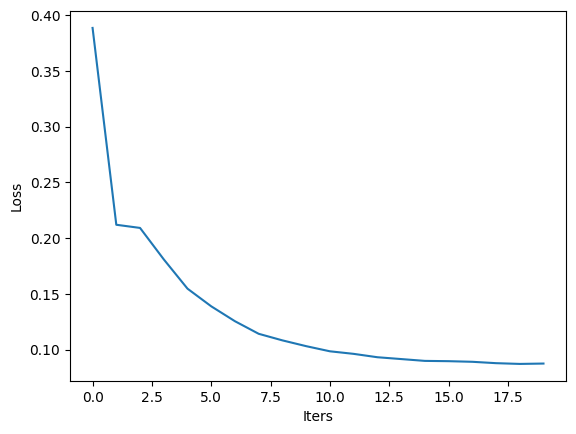

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(len(total_losses)), total_losses)
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.show()